In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm

In [2]:
# Must be set outside of top cell

plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
def stock_prices(S0, mu, sigma, T, seed=42):
    """
    Stocks with initial price S0 that grow with mean mu and std sigma over T periods
    mu is a vector of length N
    sigma is an N x N matrix 
    """
    np.random.seed(seed = seed)
    mu = np.array(mu)
    sigma = np.array(sigma)

    N = len(mu)
    W = np.random.randn(N, T)

    drift = mu - 0.5 * np.diag(np.dot(sigma, sigma.T))
    vol = np.dot(sigma, W)
    increments = drift[:, np.newaxis] + np.cumsum(vol, axis=1)
    return np.concatenate((S0, S0 * np.exp(increments)), axis=1)

def market_cap_portfolio(stocks):
    S0 = stocks[:, 0]
    return stocks.sum(axis=0) / S0.sum()

def equal_weight_portfolio(stocks):
    returns = stocks[:, 1:] / stocks[:, :-1]
    N = stocks.shape[0]
    portfolio = np.ones([N]) / N
    portfolio_returns = np.dot(portfolio, returns)
    return np.concatenate((np.array([1]), np.cumprod(portfolio_returns)))
    
def gmean(x):
    return np.exp(np.mean(np.log(x)))

def gstd(x):
    return np.exp(np.mean(np.log(x) - np.log(gmean(x)) ** 2))

def cummax(x):
    return np.maximum.accumulate(x)

def statistics(portfolio):
    portfolio = np.array(portfolio)
    returns = portfolio[1:] / portfolio[:-1]
    mean = gmean(returns) - 1.
    std = np.std(returns)
    return pd.Series({
        'mean': mean,
        'std':std,
        'sharp': mean / std,
        'drawdown': np.max((cummax(portfolio) - portfolio) / cummax(portfolio)),
        'terminal': portfolio[-1]
    })
    
def plot_results(stocks):
    fig, axes = plt.subplots(1, 2, tight_layout=True)

    pd.DataFrame(
        (stocks / stocks[:, 0][:, np.newaxis]).T,
        columns=["Stock {}".format(i) for i in range(stocks.shape[0])]
    ).plot(ax=axes[0])

    portfolios = pd.DataFrame({
        'market_cap': market_cap_portfolio(stocks),
        'equal_weight': equal_weight_portfolio(stocks),
    })
    
    portfolios.plot(ax=axes[1])
    
    return portfolios.apply(statistics)

# 2 Stocks

,market_cap,equal_weight
mean,0.003035,0.002034
std,0.239403,0.228032
sharp,0.012677,0.008921
drawdown,0.913301,0.919799
terminal,1.438553,1.276184


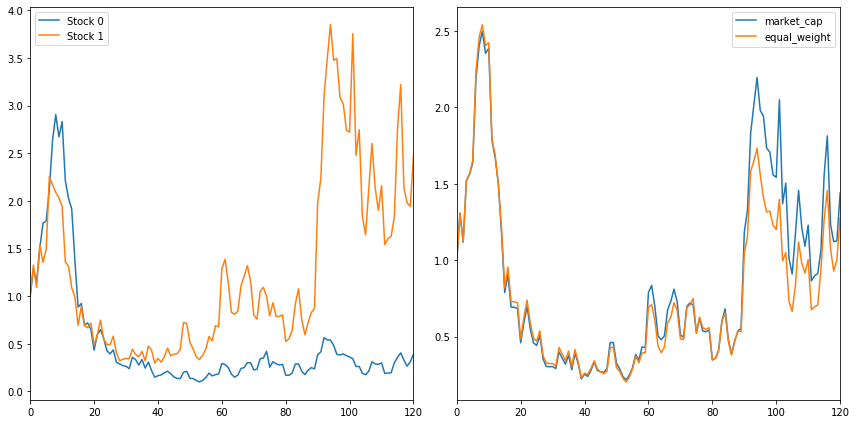

In [4]:
T = 120
mu = np.ones([2]) * 0.1
sigma = [[.2, .1], [.1, .2]]
seed = 42
S0 = np.ones([2, 1])
stocks = stock_prices(S0, mu, sigma, T, seed=42)
plot_results(stocks)

# 10 Stocks with various starting prices

,market_cap,equal_weight
mean,0.030221,0.022481
std,0.102812,0.060830
sharp,0.293945,0.369564
drawdown,0.541877,0.438792
terminal,19.635667,9.236423


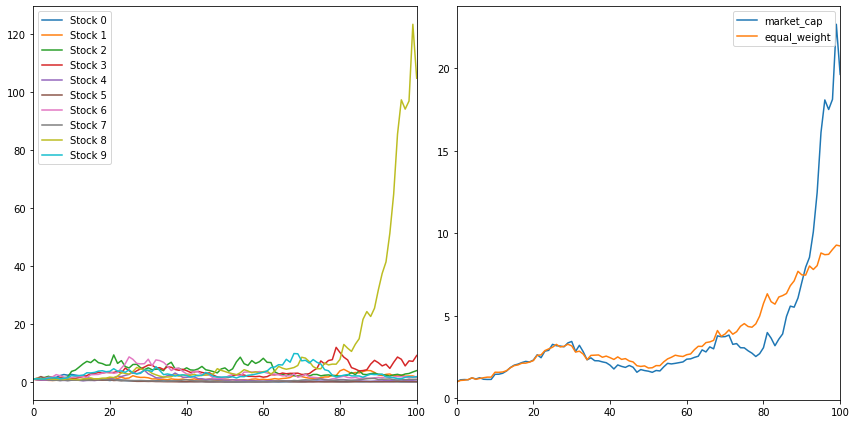

In [5]:
T = 100
N = 10
mu = np.ones([N]) * 0.1
sigma = np.diag(np.ones([N]) * 0.2)
seed = 42
S0 = np.exp(np.arange(N)/5)[:, np.newaxis]
stocks = stock_prices(S0, mu, sigma, T, seed=42)
plot_results(stocks)

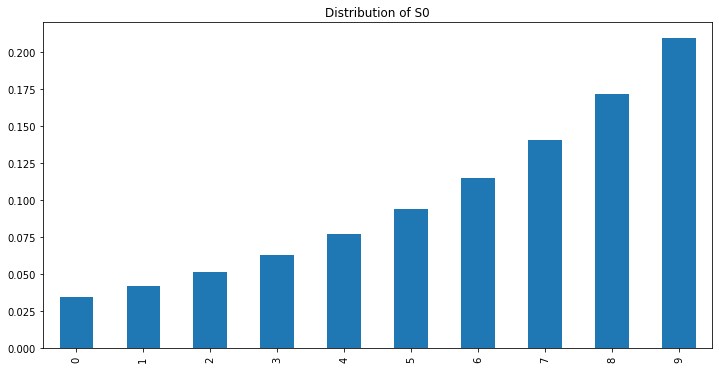

In [6]:
pd.Series(np.ndarray.flatten(S0 / S0.sum())).plot.bar(title='Distribution of S0');

# Breakdown of S&P 500

As of June 11, 2019, half of the S&P 500 is in the top 50 stocks

In [7]:
df = pd.read_html("./html/SP500.html", flavor='lxml')[0]
df['Weight'][:50].sum()

50.641189

As of November 30, 2018, the breakdown of sectors in the S&P 500 was as follows:

- Information Technology – 19.9 percent
- Health Care – 15.8 percent
- Financials – 13.7 percent
- Consumer Discretionary – 9.9 percent
- Communications Services – 9.9 percent
- Industrials – 9.4 percent
- Consumer Staples – 7.4 percent
- Energy – 5.4 percent
- Utilities – 3.1 percent
- Real Estate – 2.9 percent
- Materials - 2.6 percent


From [Source](https://www.thebalance.com/what-is-the-sector-weighting-of-the-s-and-p-500-4579847)


# Simulation with 10 stocks

In [8]:
T = 100
N = 10
mu = np.ones([N]) * 0.1
sigma = np.diag(np.ones([N]) * 0.2)
seed = 42
S0 = np.exp(np.arange(N)/5)[:, np.newaxis]
M = 5000

def generate_statistics(M):
    portfolios = (market_cap_portfolio, equal_weight_portfolio)
    results = defaultdict(list)
    for seed in tqdm(range(M)):
        stocks = stock_prices(S0, mu, sigma, T, seed=seed)
        for portfolio in portfolios:
            results[portfolio.__name__] += [statistics(portfolio(stocks))]
    
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(v)
        df.columns = [[k] * len(v[0]), v[0].index]
        dfs += [df]
    return pd.concat(dfs, axis=1)

port_stats = generate_statistics(M)

100%|██████████| 5000/5000 [00:05<00:00, 976.26it/s] 


In [9]:
port_stats.head()

market_cap_portfolio                                           \
                  mean       std     sharp  drawdown   terminal   
0             0.019041  0.112928  0.168612  0.437977   6.594248   
1             0.016131  0.096181  0.167710  0.524283   4.953956   
2             0.022614  0.115700  0.195454  0.645685   9.357912   
3             0.030730  0.139109  0.220906  0.674275  20.629842   
4             0.018045  0.097477  0.185122  0.567724   5.980065   

  equal_weight_portfolio                                           
                    mean       std     sharp  drawdown   terminal  
0               0.009272  0.065332  0.141923  0.471263   2.516665  
1               0.026293  0.061572  0.427027  0.162574  13.401089  
2               0.009745  0.064977  0.149974  0.457377   2.637349  
3               0.022978  0.064655  0.355392  0.221120   9.696629  
4               0.027813  0.064149  0.433560  0.323611  15.537964

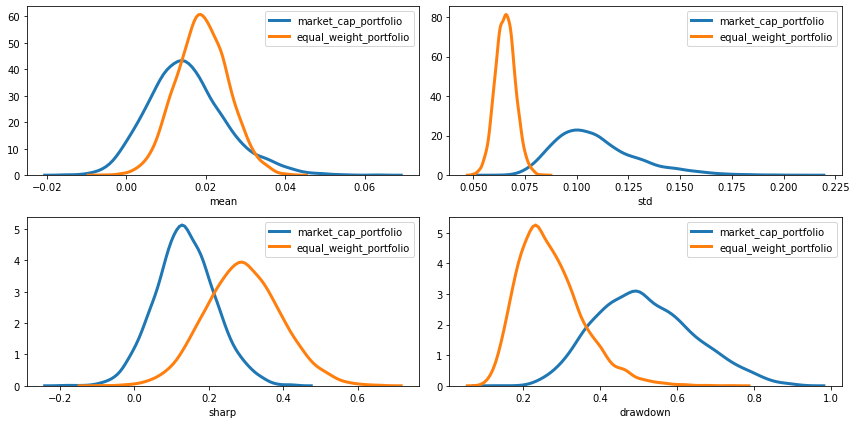

In [10]:
_, axes = plt.subplots(2, 2, tight_layout=True)
axes = np.ndarray.flatten(axes)
cols = [c for c in port_stats.columns.get_level_values(1).unique() if c != 'terminal']

for ax, col in zip(axes, cols):
    df_tmp = port_stats.loc[:, (slice(None), col)]
    for port in df_tmp:
        sns.distplot(df_tmp[port], hist=False, kde=True,
                     kde_kws = {'linewidth': 3},
                     label=port[0], ax=ax)
        ax.set_xlabel(col)

In [11]:
port_stats.loc[:, (slice(None), 'mean')].describe()

,market_cap_portfolio,equal_weight_portfolio
,mean,mean
count,5000.000000,5000.000000
mean,0.015305,0.019089
std,0.009894,0.006598
min,-0.015176,-0.006032
25%,0.008606,0.014629
50%,0.014499,0.019036
75%,0.021063,0.023561
max,0.063793,0.041755


In [12]:
port_stats.loc[:, (slice(None), 'terminal')].describe()

,market_cap_portfolio,equal_weight_portfolio
,terminal,terminal
count,5000.000000,5000.000000
mean,8.028126,8.152915
std,15.781521,5.843973
min,0.216707,0.546049
25%,2.355845,4.273073
50%,4.218604,6.590763
75%,8.039626,10.265096
max,484.959529,59.779510
